# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 3: Neural Machine Translation (30 pts)
In this part, you implement Transformer encoder for Neural Machine Translation (NMT) using a sequence to sequence (seq2seq) model for English to French translation with PyTorch.

---
### 1 Transformer Encoder (18 pts)

In [73]:
# Add utilities path
import sys

path_to_utils = 'pyfiles'
sys.path.append(path_to_utils)

In [74]:
# Import custom modules
import global_variables
import nmt_dataset
import nnet_models_new

In [75]:
# Load data
import os

source_name = 'en'
target_name = 'fr'

base_saved_models_dir = '.'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = './data/'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [76]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [77]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999)) # 32
batchSize = 64

In [78]:
from functools import partial
from torch.utils.data import DataLoader

dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

In [91]:
# Configuration

# add library / configuration for positional embeddings
import torch
from torch import nn, Tensor
import math
from math import sqrt, sin, cos
from tqdm import notebook
import time

source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
hidden_size = 512
enc_layers = 1
lr = 0.01 # was 0.25 later
longest_label = 1;
gradient_clip = 0.3;
use_cuda = True

num_epochs = 20

## add config
d_model = 512
n_heads = 2
dropout = 0.1

#### 1.1 Encoder (9 pts)

In [92]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [93]:
# Add transformer as encoder in seq2seq model
class EncoderTransformer(nn.Module):
    
    def __init__(self, n_vocab, d_model, n_heads, d_hid, enc_layers, dropout):

        super().__init__()
        
        # you need to add more things here
        
        # this code was referenced from pytorch documentation
        self.embed = nn.Embedding(n_vocab, d_model, padding_idx=global_variables.PAD_IDX)
        self.pos_embed = PositionalEncoding(d_model, dropout) # sinusoidal embedding
        self.d_model = d_model
        
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, d_hid, dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, enc_layers)
        
        # initialization of weight
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embed.weight.data.uniform_(-initrange, initrange)        

    def forward(self, text_vec, hidden=None): # we set hidden to None at the first place 
        # some helpful directions below, check the MLM lab for more details
        
        # this code was referenced from pytorch documentation
        src = self.embed(text_vec) * math.sqrt(self.d_model)
        src = self.pos_embed(src)

        output = self.transformer(src)

        # we also need to get hidden state to pass encoder to decoder
        # here, we take initialize hidden state to zero, and change the dimension shape 
        # this allows decoder to use hidden state defined on here 
        
        hidden = torch.zeros(1, output.size(0), output.size(2), device = text_vec.device)
        
        return output, hidden

In [94]:
encoder = EncoderTransformer(n_vocab=source_vocab, d_model=d_model, n_heads=n_heads, \
                             d_hid=hidden_size, enc_layers=enc_layers, dropout=dropout)

#### 1.2 Decoder(s) (9 pts)

In [95]:
# Basic RNN decoder (no attention)
encoder = EncoderTransformer(n_vocab=source_vocab, d_model=d_model, n_heads=n_heads, \
                             d_hid=hidden_size, enc_layers=enc_layers, dropout=dropout)

decoder_rnn_1 = nnet_models_new.DecoderRNN(target_vocab, hidden_size, enc_layers)

full_model_1 = nnet_models_new.seq2seq(encoder, decoder_rnn_1,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = 2, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [39]:
# RNN Decoder with Encoder attention
encoder = EncoderTransformer(n_vocab=source_vocab, d_model=d_model, n_heads=n_heads, \
                             d_hid=hidden_size, enc_layers=enc_layers, dropout=dropout)

decoder_rnn_2 = nnet_models_new.Decoder_SelfAttn(target_vocab, hidden_size, \
                                                 self_attention = False, encoder_attention = True)

full_model_2 = nnet_models_new.seq2seq(encoder, decoder_rnn_2,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = 2, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [13]:
# RNN Decoder with Encoder & Self attention
encoder = EncoderTransformer(n_vocab=source_vocab, d_model=d_model, n_heads=n_heads, \
                             d_hid=hidden_size, enc_layers=enc_layers, dropout=dropout)

decoder_rnn_3 = nnet_models_new.Decoder_SelfAttn(target_vocab, hidden_size, \
                                                 self_attention = True, encoder_attention = True)

full_model_3 = nnet_models_new.seq2seq(encoder, decoder_rnn_3,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = 2, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

#### Training & Evaluation

In [96]:
## this function was referenced by lab 

def train_model(dataloader, nmt, num_epochs=50, val_every=1):
    
    # create loss and bleu score lists
    train_loss_list = []
    val_bleu_list = []
    
    best_bleu = -1;
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in notebook.tqdm(enumerate(dataloader['train']), total=len(dataloader['train'])):  
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train']) 
        
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        
        # save to loss list
        train_loss_list.append(epoch_loss)
        
        sys.stdout.flush()
   
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score)
            
            # save to bleu score list 
            val_bleu_list.append(val_bleu_score)            
            
            sys.stdout.flush()
            
            nmt.scheduler_step(val_bleu_score);
            
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))
    
    return train_loss_list, val_bleu_list

In [98]:
import gc
gc.collect()

139

In [99]:
# training for model 1
train_loss_list_1, val_bleu_list_1 = train_model(dataloader_dict,
                                                 full_model_1, 
                                                 num_epochs = num_epochs)

Epoch: [0/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 0 loss = 2.3173973591373898, time = 191.81547117233276
validation bleu:  2.5788499421936164
Epoch: [1/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 1 loss = 1.686282036542232, time = 189.65513348579407
validation bleu:  5.430307746115325
Epoch: [2/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 2 loss = 1.4954081657520621, time = 189.9128384590149
validation bleu:  7.588506991749392
Epoch: [3/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 3 loss = 1.3797105601950035, time = 189.7223460674286
validation bleu:  9.024346239675518
Epoch: [4/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 4 loss = 1.2779946407783065, time = 189.84810614585876
validation bleu:  10.660338484776538
Epoch: [5/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 5 loss = 1.2011383356810277, time = 189.84305787086487
validation bleu:  12.013279624668858
Epoch: [6/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 6 loss = 1.126222814186128, time = 190.00930953025818
validation bleu:  13.547745832052469
Epoch: [7/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 7 loss = 1.0662760284798958, time = 190.04612398147583
validation bleu:  14.903407367640371
Epoch: [8/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 8 loss = 1.0153153050309074, time = 190.01752066612244
validation bleu:  16.09046054060169
Epoch: [9/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 9 loss = 0.9650892060219086, time = 190.01508402824402
validation bleu:  16.96891165328437
Epoch: [10/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 10 loss = 0.9223149665835161, time = 190.3486044406891
validation bleu:  17.961444282727825
Epoch: [11/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 11 loss = 0.8827058421938043, time = 190.67513179779053
validation bleu:  18.968284719297326
Epoch: [12/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 12 loss = 0.8496702580901064, time = 190.6039535999298
validation bleu:  19.462667113193206
Epoch: [13/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 13 loss = 0.8172979349409775, time = 190.51963067054749
validation bleu:  19.969067365639493
Epoch: [14/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 14 loss = 0.7845120264552636, time = 190.3377661705017
validation bleu:  20.769418981565178
Epoch: [15/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 15 loss = 0.7627882436371907, time = 190.15356016159058
validation bleu:  21.30098395907071
Epoch: [16/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 16 loss = 0.7341580189331086, time = 190.36274003982544
validation bleu:  21.824887499764795
Epoch: [17/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 17 loss = 0.7093946068735995, time = 190.56483554840088
validation bleu:  22.452954134055034
Epoch: [18/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 18 loss = 0.6905291024007295, time = 190.48179507255554
validation bleu:  22.875562070120235
Epoch: [19/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 19 loss = 0.6663589086559011, time = 190.1974265575409
validation bleu:  23.53231385642179
Training completed. Best BLEU is 23.53231385642179


In [41]:
train_loss_list_2, val_bleu_list_2 = train_model(dataloader_dict, 
                                                 full_model_2,
                                                 num_epochs = num_epochs)

Epoch: [0/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 0 loss = 2.3368878257571826, time = 351.5087962150574
validation bleu:  4.635453831480418
Epoch: [1/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 1 loss = 1.6703772253276898, time = 347.554936170578
validation bleu:  9.074029572901251
Epoch: [2/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 2 loss = 1.4778917810263066, time = 347.33016061782837
validation bleu:  11.431114758909764
Epoch: [3/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 3 loss = 1.3550885660496446, time = 347.3911533355713
validation bleu:  13.92842825373875
Epoch: [4/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 4 loss = 1.275637935568421, time = 347.78133726119995
validation bleu:  14.918262334078534
Epoch: [5/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 5 loss = 1.2133270483267935, time = 347.03429913520813
validation bleu:  15.53511303245188
Epoch: [6/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 6 loss = 1.1630848913311629, time = 346.8055021762848
validation bleu:  17.095940681162926
Epoch: [7/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 7 loss = 1.1194120242985333, time = 347.4914753437042
validation bleu:  17.781887955781446
Epoch: [8/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 8 loss = 1.0831025377204875, time = 345.0567536354065
validation bleu:  18.454448890882162
Epoch: [9/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 9 loss = 1.0509959584458053, time = 373.19202041625977
validation bleu:  19.415750383866683
Epoch: [10/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 10 loss = 1.0211819381594989, time = 347.7383334636688
validation bleu:  19.021531996651
Epoch 00011: reducing learning rate of group 0 to 1.0000e-03.
Epoch: [11/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 11 loss = 0.9636138584144888, time = 347.49956703186035
validation bleu:  21.35042707704375
Epoch: [12/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 12 loss = 0.9406187744186856, time = 347.81449484825134
validation bleu:  21.9207282115149
Epoch: [13/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 13 loss = 0.9250218183049865, time = 348.8601052761078
validation bleu:  22.096426182895094
Epoch: [14/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 14 loss = 0.9191159551823899, time = 347.54407477378845
validation bleu:  22.39835315092481
Epoch: [15/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 15 loss = 0.9094495079523969, time = 347.6450572013855
validation bleu:  22.8258853219452
Epoch: [16/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 16 loss = 0.9015599965223645, time = 347.8947944641113
validation bleu:  22.719454384956013
Epoch 00017: reducing learning rate of group 0 to 1.0000e-04.
Epoch: [17/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 17 loss = 0.8940530428265601, time = 347.0649492740631
validation bleu:  22.86662722251244
Epoch: [18/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 18 loss = 0.8935987130261525, time = 347.4994306564331
validation bleu:  22.72565272685963
Epoch: [19/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 19 loss = 0.8869622724208145, time = 349.0776529312134
validation bleu:  23.06601783248178
Training completed. Best BLEU is 23.06601783248178


In [38]:
train_loss_list_3, val_bleu_list_3 = train_model(dataloader_dict, 
                                                 full_model_3,
                                                 num_epochs = num_epochs)

Epoch: [0/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 0 loss = 2.2756917987173613, time = 361.86591601371765
validation bleu:  6.526400047573199
Epoch: [1/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 1 loss = 1.6673961534064232, time = 359.57522892951965
validation bleu:  9.043820329629744
Epoch: [2/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 2 loss = 1.500848271609013, time = 359.3349075317383
validation bleu:  11.994129105290314
Epoch: [3/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 3 loss = 1.3805413307245418, time = 360.51149821281433
validation bleu:  14.040410618636262
Epoch: [4/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 4 loss = 1.2873943040245457, time = 360.4787015914917
validation bleu:  15.821888186248485
Epoch: [5/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 5 loss = 1.2156704756361625, time = 359.86116909980774
validation bleu:  17.03297949136329
Epoch: [6/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 6 loss = 1.1627544977988562, time = 360.01660537719727
validation bleu:  17.65718648493358
Epoch: [7/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 7 loss = 1.116084135470298, time = 360.7387397289276
validation bleu:  19.133455879833303
Epoch: [8/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 8 loss = 1.0838156877462224, time = 360.466285943985
validation bleu:  19.092884577832287
Epoch 00009: reducing learning rate of group 0 to 1.0000e-03.
Epoch: [9/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 9 loss = 1.0174181548512213, time = 360.3776202201843
validation bleu:  21.171647626156453
Epoch: [10/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 10 loss = 0.991972114207672, time = 356.91411232948303
validation bleu:  21.701791706632278
Epoch: [11/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 11 loss = 0.9776330930704555, time = 355.54033946990967
validation bleu:  22.359980964997266
Epoch: [12/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 12 loss = 0.9627844315156382, time = 357.83512687683105
validation bleu:  22.14532227029806
Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Epoch: [13/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 13 loss = 0.9577543193283504, time = 356.57693696022034
validation bleu:  22.41876558855496
Epoch: [14/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 14 loss = 0.9552340944387906, time = 356.9479932785034
validation bleu:  22.442251224624442
Epoch: [15/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 15 loss = 0.9521781632444535, time = 357.0689296722412
validation bleu:  22.616538469426516
Epoch: [16/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 16 loss = 0.9524512121882135, time = 358.5739998817444
validation bleu:  22.589799595668506
Epoch: [17/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 17 loss = 0.9514732524298565, time = 362.63212156295776
validation bleu:  22.552642611751576
Epoch: [18/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 18 loss = 0.9483249353239741, time = 362.37299704551697
validation bleu:  22.542840837415476
Epoch: [19/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 19 loss = 0.9486471589582448, time = 361.4890413284302
validation bleu:  22.54276269282344
Training completed. Best BLEU is 22.616538469426516


In [43]:
## this code was referenced on lab codes 

import copy
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

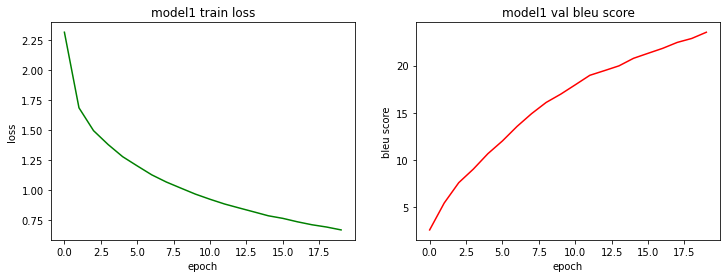

In [100]:
## model1
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
plt.plot(train_loss_list_1, 'green')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model1 train loss')

ax2 = fig.add_subplot(122)
plt.plot(val_bleu_list_1, 'red')
plt.xlabel('epoch')
plt.ylabel('bleu score')
plt.title('model1 val bleu score')

plt.show()

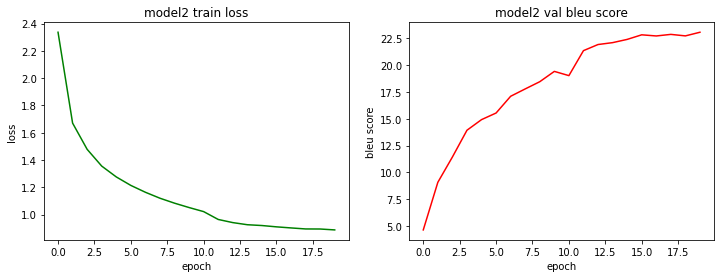

In [44]:
## model2
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
plt.plot(train_loss_list_2, 'green')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model2 train loss')

ax2 = fig.add_subplot(122)
plt.plot(val_bleu_list_2, 'red')
plt.xlabel('epoch')
plt.ylabel('bleu score')
plt.title('model2 val bleu score')

plt.show()

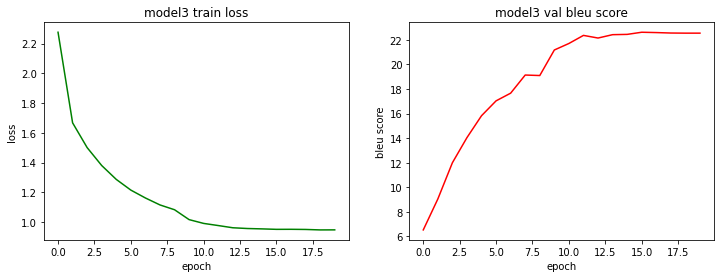

In [74]:
## model3
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
plt.plot(train_loss_list_3, 'green')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model3 train loss')

ax2 = fig.add_subplot(122)
plt.plot(val_bleu_list_3, 'red')
plt.xlabel('epoch')
plt.ylabel('bleu score')
plt.title('model3 val bleu score')

plt.show()

In [101]:
#### Reference (this is a code to save/load my model)
## model saving functions
file_path = '/home/yp2201/model_3_1.pt'
torch.save({'loss': train_loss_list_1, 
            'bleu': val_bleu_list_1, 
            'model': full_model_1}, file_path)

In [104]:
## model loading functions 
file_path = '/home/yp2201/model_3_1.pt'
model_1 = torch.load(file_path)

In [45]:
#### Reference (this is a code to save/load my model)
## model saving functions
file_path = '/home/yp2201/model_3_2.pt'
torch.save({'loss': train_loss_list_2, 
            'bleu': val_bleu_list_2, 
            'model': full_model_2}, file_path)

In [61]:
## model loading functions 
file_path = '/home/yp2201/model_3_2.pt'
model_2 = torch.load(file_path)

In [41]:
#### Reference (this is a code to save/load my model)
## model saving functions
file_path = '/home/yp2201/model_3_3.pt'
torch.save({'loss': train_loss_list_3, 
            'bleu': val_bleu_list_3, 
            'model': full_model_3}, file_path)

In [59]:
## model loading functions 
file_path = '/home/yp2201/model_3_3.pt'
model_3 = torch.load(file_path)

---
### 2 Attention visualization (12 pts)

1. Select 3 examples from the validation set and print out the input sentence 
    in the source language and the predicted sentence in the target language for each type of encoder.
2. For 3.2.B, print out the cross-attention heatmap.
3. For 3.2.C, print out the cross-attention heatmap and the decoder’s self-attention heatmap.

In [49]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       [global_variables.EOS_TOKEN]);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device), 
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple

def get_translation(nmt_model, sentence, target, lang_obj, use_cuda):
    print('original source: ', sentence)
    print('original target: ', target)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    print('prediction: ', prediction)

    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

In [56]:
dataset_dict['val'].main_df.iloc[:3, :]

,source_data,target_data,source_tokenized,source_len,target_tokenized,target_len,source_indized,target_indized
0,you seem happy .,vous avez l air heureux .,"[you, seem, happy, .]",5,"[vous, avez, l, air, heureux, .]",7,"[11, 1095, 786, 17, 3]","[14, 135, 19, 374, 910, 21, 3]"
1,what right do you have to order us around ?,de quel droit nous donnes tu des ordres ?,"[what, right, do, you, have, to, order, us, ar...",11,"[de, quel, droit, nous, donnes, tu, des, ordre...",10,"[103, 578, 31, 11, 8, 23, 501, 327, 670, 36, 3]","[17, 968, 1029, 7, 3931, 64, 168, 3958, 39, 3]"
2,business expenses are tax deductible .,les depenses d affaires sont deductibles des i...,"[business, expenses, are, tax, deductible, .]",7,"[les, depenses, d, affaires, sont, deductibles...",10,"[407, 1840, 58, 4640, 7094, 17, 3]","[58, 2370, 110, 469, 113, 10656, 168, 7210, 21..."


In [57]:
# 1. Select 3 examples from the validation set and print out the input sentence 
# in the source language and the predicted sentence in the target language for each type of encoder.
# (3 examples for other models are shown on codes blocks after this)

# using examples to all 3 examples
# those variables will be continously used in other models 
sample_dataset = dataset_dict['val'].main_df.iloc[:3, :]
source = sample_dataset.iloc[:, 0]
target = sample_dataset.iloc[:, 1]

In [103]:
# 1. For 3.2.A
for i in range(3):
    print('example:', i+1)
    get_translation(full_model_1, source.values[i], target.values[i], source_lang_obj, use_cuda)
    print()

example: 1
original source:  you seem happy .
original target:  vous avez l air heureux .
prediction:  tu heureuse heureuse heureuse . tu heureuse heureuse . heureuse . heureuse heureuse .

example: 2
original source:  what right do you have to order us around ?
original target:  de quel droit nous donnes tu des ordres ?
prediction:  que devons nous faire ce que tu as a faire ?

example: 3
original source:  business expenses are tax deductible .
original target:  les depenses d affaires sont deductibles des impots .
prediction:  les fruits sont de certaines differentes pour les fruits de la societe des animaux .



example: 1
original source:  you seem happy .
original target:  vous avez l air heureux .
prediction:  heureux vous un seul heureuse que vous semblez heureux .


<ipython-input-49-371988fbfe29>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-49-371988fbfe29>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words.split(' ')+


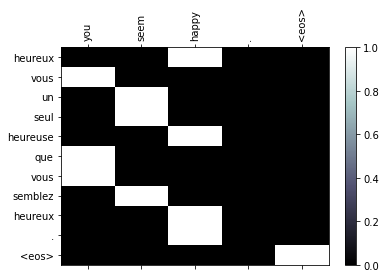

example: 2
original source:  what right do you have to order us around ?
original target:  de quel droit nous donnes tu des ordres ?
prediction:  que nous a t il droit que tu nous a raison ?


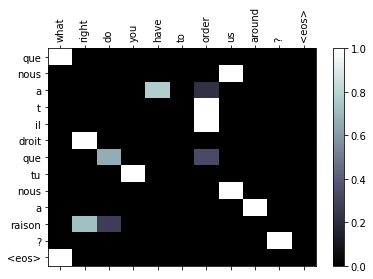

example: 3
original source:  business expenses are tax deductible .
original target:  les depenses d affaires sont deductibles des impots .
prediction:  les affaires sont des affaires sont des affaires .


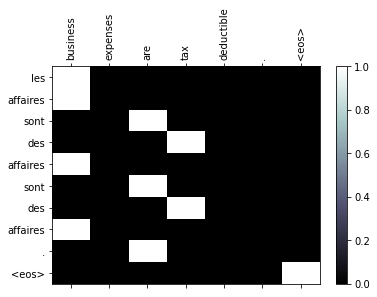

In [58]:
# 2. For 3.2.B, print out the cross-attention heatmap.
# model_2['model']

for i in range(3):
    print('example:', i+1)
    get_translation(full_model_2, source.values[i], target.values[i], source_lang_obj, use_cuda)

example: 1
original source:  you seem happy .
original target:  vous avez l air heureux .
prediction:  je me suis bien pas avoir l air heureux que tu sembles heureux .


<ipython-input-49-371988fbfe29>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-49-371988fbfe29>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words.split(' ')+


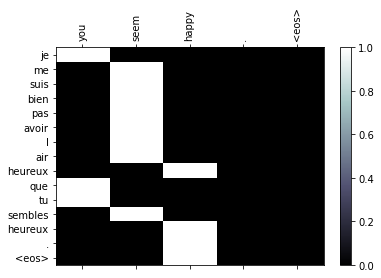

example: 2
original source:  what right do you have to order us around ?
original target:  de quel droit nous donnes tu des ordres ?
prediction:  je t ai bien raison pour ce qui est juste dans ce qui est juste dans les jours ?


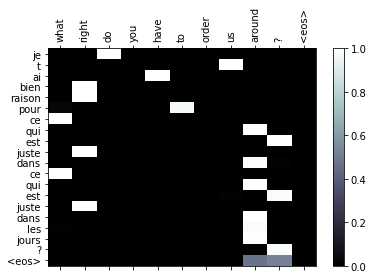

example: 3
original source:  business expenses are tax deductible .
original target:  les depenses d affaires sont deductibles des impots .
prediction:  etes vous d une fois pour la place de la moitie de la police .


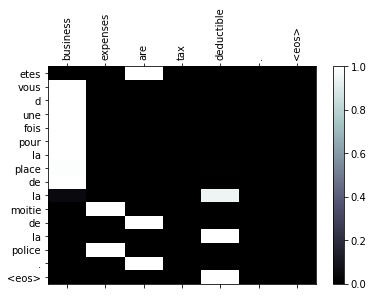

In [60]:
# 3. For 3.2.C, print out the cross-attention heatmap and the decoder’s self-attention heatmap.
# model_3['model']

for i in range(3):
    print('example:', i+1)
    get_translation(full_model_3, source.values[i], target.values[i], source_lang_obj, use_cuda)